# Demonstrating how to access AWS telemetry data stored in DyanmoDB     

In [1]:
import boto3
from boto3.dynamodb.conditions import Key

dyanmodb = boto3.resource('dynamodb', region_name="us-east-2")
telemetry_table = dyanmodb.Table('telemetry')

In [2]:
telemetry_data = telemetry_table.query(
    KeyConditionExpression=Key('test_id').eq('dev-pi')
)['Items']
print(telemetry_data)

[{'clockState': Decimal('0'), 'lastDeadman': '0', 'throttleTooHigh': Decimal('2493'), 'throttle': Decimal('0'), 'current': Decimal('0'), 'motorInitializing': Decimal('0'), 'timestamp': '1684985135233.3997', 'speed': Decimal('0'), 'test_id': 'dev-pi', 'voltage': Decimal('1394')}, {'clockState': Decimal('0'), 'lastDeadman': '0', 'throttleTooHigh': Decimal('2493'), 'throttle': Decimal('0'), 'current': Decimal('0'), 'motorInitializing': Decimal('0'), 'timestamp': '1684985135233.4448', 'speed': Decimal('0'), 'test_id': 'dev-pi', 'voltage': Decimal('1394')}, {'clockState': Decimal('0'), 'lastDeadman': '0', 'throttleTooHigh': Decimal('2493'), 'throttle': Decimal('0'), 'current': Decimal('0'), 'motorInitializing': Decimal('0'), 'timestamp': '1684985135233.4507', 'speed': Decimal('0'), 'test_id': 'dev-pi', 'voltage': Decimal('1394')}, {'clockState': Decimal('0'), 'lastDeadman': '0', 'throttleTooHigh': Decimal('2493'), 'throttle': Decimal('0'), 'current': Decimal('0'), 'motorInitializing': Decim

# Processing Data

In [4]:
from typing import List
from Telemetry import TelemetryProcessor, TelemetryDataPoint, InstantEfficiencyDataPoint

processed: List[TelemetryDataPoint] = []

for point in telemetry_data:
    processed.append(
        TelemetryDataPoint(timestamp=float(point['timestamp']), speed=float(point['speed']), voltage=float(point['voltage']), current=float(point['current']))
    )

instantEfficiencyDataPoints = TelemetryProcessor.get_inst_efficiency(processed, 10)
print(instantEfficiencyDataPoints)


[InstantEfficiencyDataPoint(timestamp=1684985135233.4636, instant_efficiency=-0.0), InstantEfficiencyDataPoint(timestamp=1684985136481.3337, instant_efficiency=-0.0)]


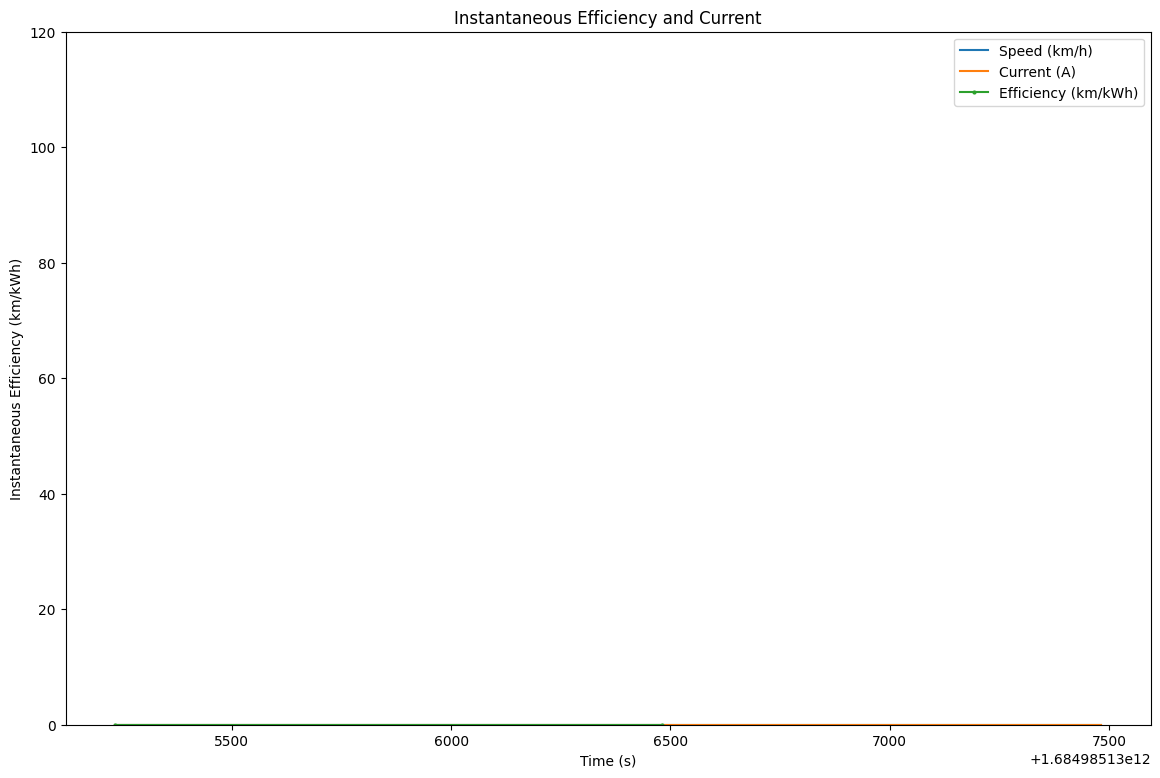

In [5]:
import matplotlib.pyplot as plt


plt.figure(figsize=(14, 9))
plt.plot([point.timestamp for point in processed], [point.speed for point in processed], "-", label="Speed (km/h)")
plt.plot([point.timestamp for point in processed], [point.current for point in processed], "-", label="Current (A)")
plt.title("Instantaneous Efficiency and Current")
plt.xlabel("Time (s)")
plt.ylabel("Instantaneous Efficiency (km/kWh)")
plt.ylim([0, 120])
# plt.xlim([0,1000])
plt.plot(
    [point.timestamp for point in instantEfficiencyDataPoints],
    [point.instant_efficiency for point in instantEfficiencyDataPoints],
    "-o",
    markersize=2,
    label="Efficiency (km/kWh)",
)
plt.legend()
plt.show()